<a href="https://colab.research.google.com/github/Shujaat123/Noisy-AE-LSE/blob/main/Noisy_Autoencoder_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Noisy-AE-LSE: Noisy bypass-Autoencoder with Latent Space Encoding**

---



**Loading Useful libraries and packages**


In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import random
!pip install wget
from random import sample

from os import path
import h5py
import keras.backend as K
import wget

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, AveragePooling2D, Dropout, Conv2DTranspose, SeparableConv2D, Add
from keras.models import Model
from keras import backend as K
from tensorflow.keras import datasets, layers, losses

**Loading dataset**

In [20]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

**Defining autoencoder(AE) model**

In [21]:
def my_model():
  input_img = Input(shape=(32, 32, 3))
  num_filter = 32
  kernel_size = 5
  strides = 1   
  
  x = Conv2D(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'enc1')(input_img)

  x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc2')(x) 
  x = AveragePooling2D((2, 2))(x)

  # x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc4')(x) 
  # x = AveragePooling2D((2, 2))(x)

  encoded = BatchNormalization()(x)
  

  x = UpSampling2D((2,2), interpolation = 'bilinear')(encoded)
  x = Conv2DTranspose(3, kernel_size, strides, activation='relu', padding='same', name = 'dec1')(x)

  # x = UpSampling2D((2,2), interpolation = 'bilinear')(x)
  # x = Conv2DTranspose(3, kernel_size, strides, activation='relu', padding='same', name = 'dec2')(x)
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'dec4')(x)
  # x = BatchNormalization()(x)
  decoded = Conv2D(3, (1, 1), activation='relu', name = 'output')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  return autoencoder

autoencoder = my_model()

In [22]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
enc1 (Conv2D)                (None, 32, 32, 32)        2432      
_________________________________________________________________
enc2 (Conv2D)                (None, 32, 32, 3)         2403      
_________________________________________________________________
average_pooling2d_4 (Average (None, 16, 16, 3)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 3)         12        
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 32, 32, 3)         0         
_________________________________________________________________
dec1 (Conv2DTranspose)       (None, 32, 32, 3)         228 

**Training autoencoder(AE) model**

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

checkpoint = ModelCheckpoint('models\\model-best.h5',
                                  verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

autoencoder.fit(train_images, train_images,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images),
                callbacks = [es, checkpoint]
                )

del autoencoder  # deletes the existing model
autoencoder = load_model('models\\model-best.h5')

Epoch 1/200
196/196 [==============================] - 7s 32ms/step - loss: 0.0702 - val_loss: 0.0276
Epoch 2/200
196/196 [==============================] - 6s 29ms/step - loss: 0.0083 - val_loss: 0.0286
Epoch 3/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0054 - val_loss: 0.0123
Epoch 4/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 5/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0037 - val_loss: 0.0071
Epoch 6/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 7/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 8/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/200
196/196 [==============================] - 6s 30ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 10/200
196/196 [==============================] - 6s 30ms/step - loss: 0.002

**Testing autoencoder(AE) model**

In [24]:
predicted_test = autoencoder.predict(test_images[:100])
predicted_test = np.clip(predicted_test, 0., 1.)

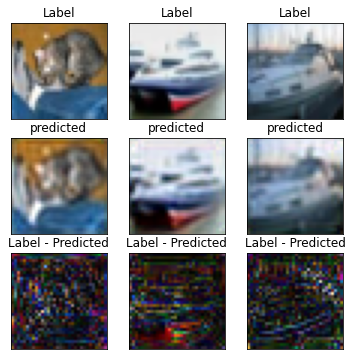

In [25]:
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("predicted")
    plt.imshow(tf.squeeze((predicted_test[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_test[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
psnr_pred = tf.image.psnr(predicted_test, test_images[:100], max_val=1.0)
print('PSNR: ', np.mean(psnr_pred))

PSNR:  27.58219


**Analyzing Noise Characteristics of autoencoder(AE) model**

In [27]:
noise_factor_uniform = 0.4
noise_factor_normal = 0.25
noise_factor_speckle = 1.2

x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

In [28]:
predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

predicted_uniform = np.clip(predicted_uniform, 0., 1.)
predicted_normal = np.clip(predicted_normal, 0., 1.)
predicted_speckle = np.clip(predicted_speckle, 0., 1.)

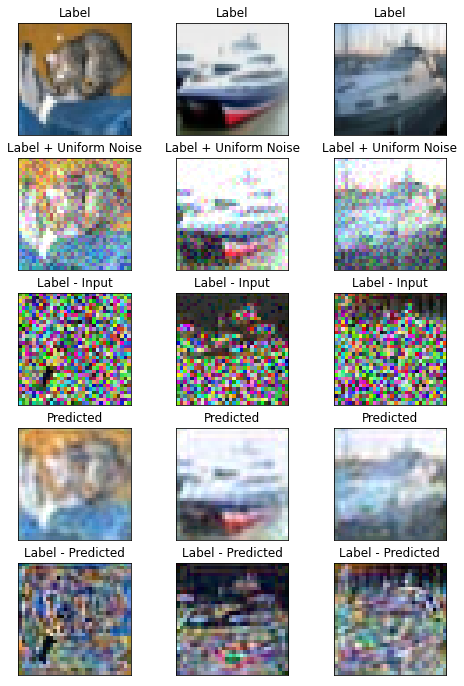

In [29]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Uniform Noise")
    plt.imshow(tf.squeeze((x_test_noisy_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_uniform[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_uniform[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

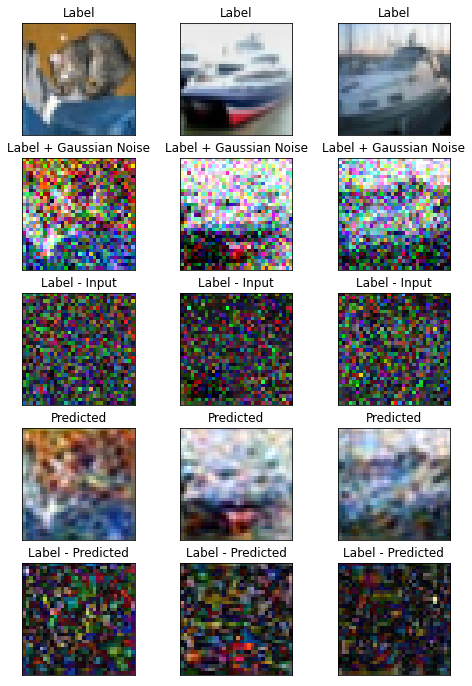

In [30]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Gaussian Noise")
    plt.imshow(tf.squeeze((x_test_noisy_normal[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_normal[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_normal[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_normal[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

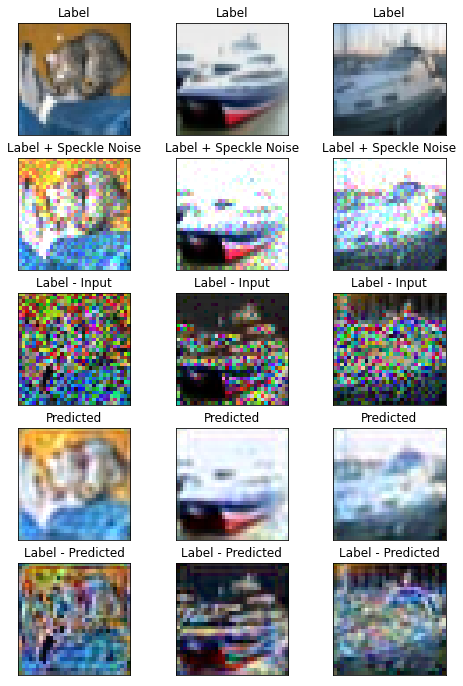

In [31]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Speckle Noise")
    plt.imshow(tf.squeeze((x_test_noisy_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_speckle[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_speckle[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [32]:
psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

Uniform:  13.478917 14.315581
Gaussian:  13.191395 19.74028
Speckle:  12.878422 13.716528


**Calculating Statistics for Noise Characteristics Curve of autoencoder(AE) model**

In [33]:
def calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder):
  x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
  x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
  x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


  x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
  x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
  x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

  predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
  predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
  predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

  predicted_uniform = np.clip(predicted_uniform, 0., 1.)
  predicted_normal = np.clip(predicted_normal, 0., 1.)
  predicted_speckle = np.clip(predicted_speckle, 0., 1.)

  psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
  psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

  psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
  psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

  psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
  psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

  print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
  print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
  print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

  return np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred), np.mean(psnr_normal_input), np.mean(psnr_normal_pred), np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred)

In [34]:
# print('----')
# noise_factor_uniform = 0.74
# noise_factor_normal = 0.5
# noise_factor_speckle = 2.8
# calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder)
PSNR_Results = []
for i in range(0,20):
  noise_factor_uniform = i*0.04
  noise_factor_normal = i*0.025
  noise_factor_speckle = i*0.12
  PSNR_Results.append(calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder))
  print('----')

PSNR_Results = np.asarray(PSNR_Results)

Uniform:  inf 27.582191
Gaussian:  inf 27.58219
Speckle:  inf 27.58219
----
Uniform:  32.858624 26.135191
Gaussian:  32.12845 27.300299
Speckle:  29.712358 25.42418
----
Uniform:  26.903967 24.129772
Gaussian:  26.198654 26.612892
Speckle:  24.09953 22.773758
----
Uniform:  23.460888 22.247114
Gaussian:  22.76618 25.661152
Speckle:  20.924444 20.637846
----
Uniform:  21.025118 20.600008
Gaussian:  20.362724 24.673635
Speckle:  18.76859 18.967894
----
Uniform:  19.141888 19.172312
Gaussian:  18.529243 23.688301
Speckle:  17.187529 17.64789
----
Uniform:  17.624767 17.939537
Gaussian:  17.041563 22.762869
Speckle:  15.961681 16.582504
----
Uniform:  16.35635 16.874762
Gaussian:  15.828853 21.907106
Speckle:  14.959382 15.674291
----
Uniform:  15.2611475 15.923349
Gaussian:  14.829111 21.108576
Speckle:  14.150182 14.925707
----
Uniform:  14.301469 15.053866
Gaussian:  13.942068 20.394394
Speckle:  13.464333 14.28486
----
Uniform:  13.480348 14.314775
Gaussian:  13.202154 19.745577
Speckl

In [35]:
from scipy.io import savemat

savemat('Noisy_AE_PSNR_Results.mat',{'PSNR_Results':PSNR_Results})

from google.colab import files
files.download("Noisy_AE_PSNR_Results.mat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

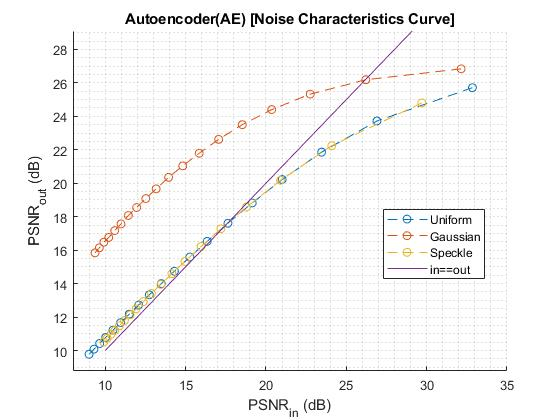

**AE-NCC for 16x16x3 (4x compression)**


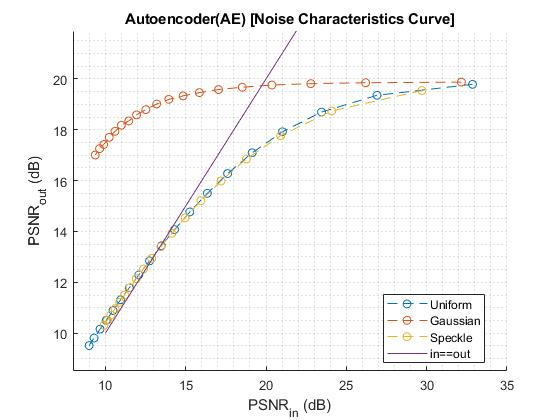

**AE-NCC for 8x8x3 (16x compression)**